# Wstęp do Sztucznej Inteligencji - rok akademicki 2019/2020

Przed rozpoczęciem pracy z notatnikiem zmień jego nazwę zgodnie z wzorem: `{NrAlbumu}_{Nazwisko}_{Imie}_{PoprzedniaNazwa}`.

Przed wysłaniem notatnika upewnij się, że rozwiązałeś wszystkie zadania/ćwiczenia.

# Temat: Optymalizacja globalna: Prosty algorytm genetyczny - Zadania
Zapoznaj się z treścią niniejszego notatnika czytając i wykonując go komórka po komórce. Wykonaj napotkane zadania/ćwiczenia.

## Import bibliotek

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

## Zadanie 1  (obowiązkowe, 1pkt.)
W komórce poniżej wprowdź swój nr albumu a następnie ją wykonaj:

In [41]:
nr_albumu = 130588
nr_funkcji = (nr_albumu % 16) + 1
print('Twój nr funkcji celu to:', nr_funkcji if nr_funkcji != 6 else 7)

Twój nr funkcji celu to: 13


Zgodnie z wygenerowanym numerem, wybierz funkcję celu ze strony: https://www.sfu.ca/~ssurjano/optimization.html z działu "Many Local Minima".

Zaplementuj ją jako funkcję w Pythonie.

Dla wszystkich funkcji przyjmujemy `N=2` tzn. rozważamy ją jako funkcję dwóch zmiennych $f(x_1, x_2)$.

TWÓJ PROGRAM:

In [42]:
def obj_func(x):
    ### SCHAFFER FUNCTION N. 2
    x1 = x[0]
    x2 = x[1]
    f1 = np.sin(x1**2-x2**2)**2 - 0.5
    f2 = (1 + 0.001*(x1**2+x2**2))**2
    return 0.5 + f1/f2

## Zadanie 2  (obowiązkowe, 1pkt.)
Przygotuj wykres 3D funkcji zaimplementowanej w zadaniu nr 1.

TWÓJ PROGRAM:

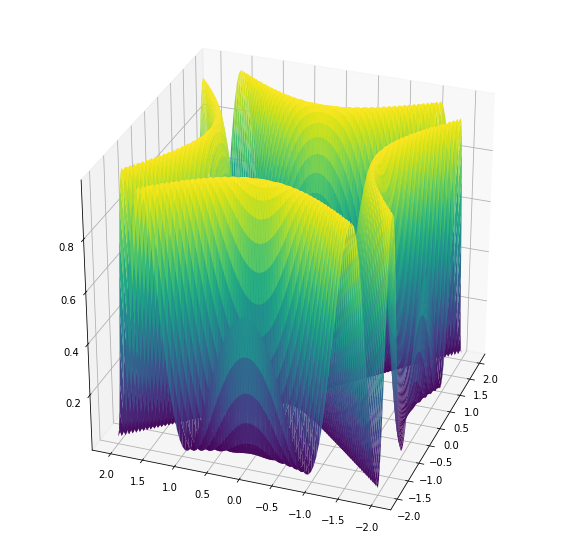

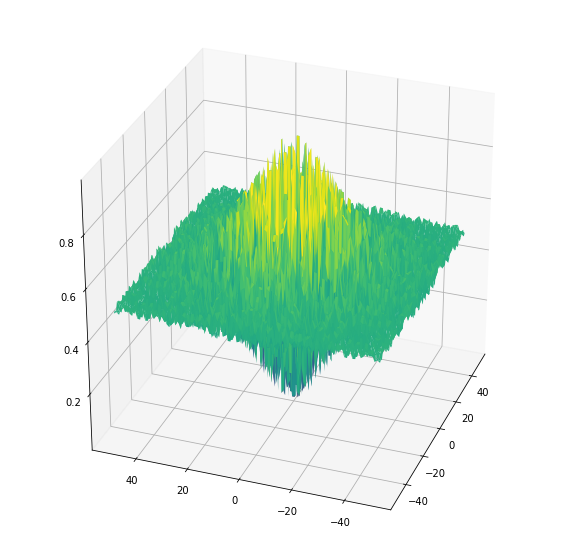

In [43]:
def print_plot(a, b, n):
  s = np.linspace(a, b, n)
  x, y = np.meshgrid(s, s)
  z = np.zeros((len(s),len(s)))

  for i in range(len(s)):
    for j in range(len(s)):
      z[i, j] = obj_func(np.array([x[i,j],y[i,j]]))

  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(111, projection='3d')

  surf = ax.plot_surface(x, y, z, rstride=1, cstride=1, cmap='viridis', linewidth=0.4, antialiased=True)
  ax.view_init(30,200)
  plt.show()

print_plot(-2, 2, 100)
print_plot(-50, 50, 100)


## Zadanie 3 (obowiązkowe, 2pkt.)
Korzystając z funkcji zaimplementowanych na poprzednich zajęciach, zaimplementuj główną pętlę klasycznego algorytmu genetyczengo.
![pag_schemat.png](http://torus.uck.pk.edu.pl/~amarsz/images/pag_schemat.png)

Implementacja powinna mieć postać funkcji, która przyjmuje parametry:

- `fun` - funkcja, której maksimum ma zostać znalezione
- `pop_size` - rozmiar populacji
- `pk` - prawdopodobieństwo krzyżowania
- `pm` - prawdopodobieństwo mutacji
- `generations` - liczba pokoleń 
- `dx` - dokładność kodowania

Funkcja powinna zwracać:
- `best_sol` - najlepsze znalezione rozwiązanie (nieważne, w której iteracji; UWAGA! niekoniecznie jest to najlepszy osobnik z ostatniej populacji)
- `best_generation` - numer pokolenia, z którego pochodzi najlepsze rozwiązanie
- `list_best` - lista z najlepszą oceną osobnika w każdym pokoleniu (najlepsza ocena znaleziona w danym pokoleniu lub wcześniej)
- `list_best_generation` - lista z najlepszymi ocenami w każdym pokoleniu (najlepsza ocena z danej populacji)
- `list_mean` - lista z wartościami średnimi ocen osobników z każdego pokolenia

TWÓJ PROGRAM:

In [44]:
def nbits(a, b, dx):
    difference = abs(b - a)
    B = int(np.ceil(difference/dx)).bit_length()
    dx_new = difference/(2**B-1)
    return B, dx_new

def gen_population(P, N, B):
    pop = np.random.randint(2, size=(P, N*B))
    return pop

def decode_individual(individual, N, B, a, dx):
    ls = []
    for i in range(N):
      ls.append(a+int(''.join(map(str, individual[i*B:(i+1)*B])),2)*dx)
    decode_individual = np.array(ls)

    return decode_individual

def evaluate_population(func, pop, N, B, a, dx):
    ls = []
    for i in pop:
      ls.append(-func(decode_individual(i, N, B, a, dx)))
    evaluated_pop = np.array(ls)
    return evaluated_pop

def get_best(pop, evaluated_pop):
    idx = np.where(evaluated_pop == evaluated_pop.max())[0][0]
    best_individual = pop[idx]
    best_value = evaluated_pop[idx]

    return best_individual, best_value

def roulette(pop, evaluated_pop):
    minimum = np.min(evaluated_pop)

    if minimum <= 0:
      t = evaluated_pop + np.abs(minimum) + 1
    else:
      t = evaluated_pop

    s = np.cumsum(t).tolist()
    s.insert(0, 0.0)
    ls = []
    for i in range(len(pop)):
      p = np.random.random() * s[-1]
      for j in range(1, len(s)):
        if s[j-1] < p < s[j]:
          ls.append(pop[j-1])
          break
    new_pop = np.array(ls)
    return new_pop

def cross(pop, pk):
    new_pop = pop.copy()
    for i in range(0, len(pop), 2):
      if i+1 >= len(pop):
        break
      p = np.random.random()
      if p < pk:
        nb = np.random.randint(1, len(pop[i]))
        t = new_pop[i].copy()
        new_pop[i][:nb] = new_pop[i+1][:nb]
        new_pop[i+1][:nb] = t[:nb]
    return new_pop

def mutate(pop, pm):
    new_pop = pop.copy()
    for i in range(len(pop)):
      for j in range(len(pop[i])):
        p = np.random.random()
        if p < pm:
          new_pop[i, j] = 0 if new_pop[i,j]==1 else 1
    return new_pop

def evolve(fun, pop_size, pk, pm, generations, dx):
    B, dx2 = nbits(a, b, dx)
    pop = gen_population(pop_size, N, B)
    evaluated_pop = evaluate_population(fun, pop, N, B, a, dx2)
    best_individual, best_value = get_best(pop, evaluated_pop)

    best_sol = best_value #najlepsze znalezione rozwiązanie (nieważne, w której iteracji; UWAGA! niekoniecznie jest to najlepszy osobnik z ostatniej populacji)
    best_generation = 0 #numer pokolenia, z którego pochodzi najlepsze rozwiązanie
    list_best = [-best_value] #lista z najlepszą oceną osobnika w każdym pokoleniu (najlepsza ocena znaleziona w danym pokoleniu lub wcześniej)
    list_best_generation = [-best_value] # lista z najlepszymi ocenami w każdym pokoleniu (najlepsza ocena z danej populacji)
    list_mean = [-np.average(evaluated_pop)] #lista z wartościami średnimi ocen osobników z każdego pokolenia
    list_pop = [pop]

    for i in range(generations):
        pop = roulette(pop, evaluated_pop) #selekcja
        pop = cross(pop, pk) #krzyżowanie
        pop = mutate(pop, pm) #mutacja

        if i == int(generations/2):
          list_pop.append(pop)
        elif i == generations - 1:
          list_pop.append(pop)

        #oceń osobniki w populacji
        evaluated_pop = evaluate_population(fun, pop, N, B, a, dx2)
        t_best_individual, t_best_value = get_best(pop, evaluated_pop)

        #znajdź i zapamiętaj najlepsze rozwiązanie, jeśli jest lepsze niż dotychczasowe najlepsze
        #uaktualnij listy statystyk
        list_mean.append(-np.average(evaluated_pop))
        list_best_generation.append(-t_best_value)
        if t_best_value > best_sol:
          best_sol = t_best_value
          best_generation = i
        list_best.append(-best_sol)
        
        
    return -best_sol, best_generation, list_best, list_best_generation, list_mean, list_pop

## Zadanie 4 (obowiązkowe, 1pkt.)

Zaprezentuj działanie algorytmu z przykładowymi wartościami parametrów:

- `pop_size`: 60
- `pk`: 0.7
- `pm`: 0.01
- `generations`: 200
- `dx`: 1e-10

Na wykresach funkcji 3D przedstaw położenie osobników z pierwszej populacji, w połowie ewolucji oraz końcowej populacji. Zaznacz wyraźnie położenie najlepszeg rozwiązania.

Na wykresach 2D przedstaw przebieg wartości z list z zebranymi statystykami (listy `list_best`, `list_best_generation`, `list_mean`) w zależności od numeru pokolenia. 

TWÓJ PROGRAM:

96


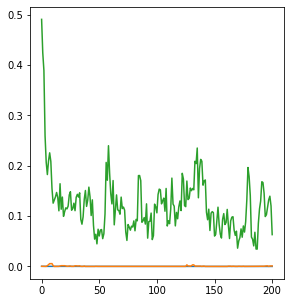

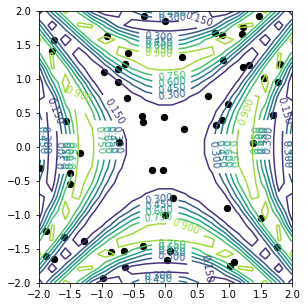

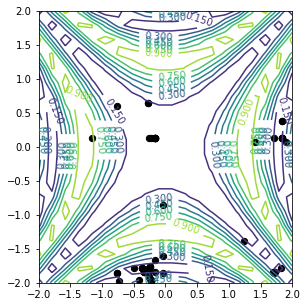

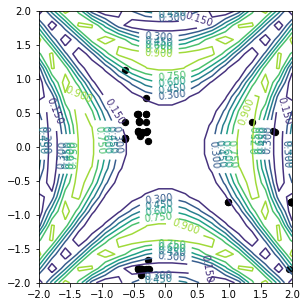

In [45]:
import time

a = -2.0
b = 2.0
N = 2
pop_size = 60
pk = 0.07
pm = 0.01
generations = 200
dx = 1e-10

best_sol, best_generation, list_best, list_best_generation, list_mean, list_pop = evolve(obj_func, pop_size, pk, pm, generations, dx)

def plot_2d(l_best, l_best_generation, l_mean):
  fig = plt.figure(figsize=(10,5))
  ax = fig.add_subplot(122)

  ax.plot(l_best)
  ax.plot(l_best_generation)
  ax.plot(l_mean)

def plot_3d(l_pop):
  B, dx2 = nbits(a, b, dx)
  fig1 = plt.figure(figsize=(10,5))
  ax1 = fig1.add_subplot(121)
  fig2 = plt.figure(figsize=(10,5))
  ax2 = fig2.add_subplot(121)
  fig3 = plt.figure(figsize=(10,5))
  ax3 = fig3.add_subplot(121)

  axis = [ax1, ax2, ax3]

  for i, pop in enumerate(l_pop):
    pop_d = []
    for indi in pop:
      pop_d.append(decode_individual(indi, N, B, a, dx2))
    pop_d = np.array(pop_d)
    axis[i].scatter(pop_d[:,0], pop_d[:,1], color='k', s=40)
    sampled = np.linspace(a,b, 20)
    x, y = np.meshgrid(sampled, sampled)
    z = np.zeros((len(sampled), len(sampled)))

    for j in range(len(sampled)):
      for k in range(len(sampled)):
        z[j, k] = obj_func(np.array([x[j,k], y[j,k]]))

    CS = axis[i].contour(x, y, z)
    axis[i].clabel(CS, inline=1, fontsize=10)
    axis[i].set_xlim(a,b)
    axis[i].set_ylim(a,b)

plot_2d(list_best, list_best_generation, list_mean)
plot_3d(list_pop)
print(best_generation)

## Zadanie 5 (obowiązkowe, 5pkt.)

Zbadaj wpływ parametrów klasycznego algorytmu genetycznego na jego zdolność znalezienia optymalnego rozwiązania. Dla ułatwienia analizy, zmieniając jeden parametr, zachowaj typowe wartości pozostałych.

1. Jak działa algorytm z typowymi ustawieniami parametrów (jak w zadaniu 4)? Podaj średnią wartość przystosowania znalezionego rozwiązania po wielokrotnym uruchomieniu AG.
2. Czy wydłużenie ewolucji przynosi poprawę czy też następuje "nasycenie"? Porównaj zarówno jak dobre rozwiązanie zostało znalezione jak również w której generacji.
    - `generations`: kilka różnych wartości z przedziału [100, 10000]
3. Czy mutacja jest potrzebna? 
    - `pm` = 0.0
4. Jak działa algorytm bez krzyżowania, z samą mutacją? 
    - `pk` = 0.0
5. Czy lepiej jest dłużej ewoluować mniejszą populację czy krócej większą, jeśli liczba ewaluacji funkcji jest taka sama (np. 2000)?
    - porównaj dwa ustawienia: `pop_size`=20, `generations`=100  vs. `pop_size`=100, `generations`=20.

UWAGA: Powyższe porównania powinny być wykonane na podstawie uśrednionych wyników co najmniej 10 uruchomień algorytmu z danymi parametrami. Podając wyniki podaj średnią z najlepszych znalezionych rozwiązań oraz odchylenie standardowe oraz numer pokolenia, w którym znaleziono rozwiązanie.

TWÓJ PROGRAM:

In [52]:
import random
a = -100.0
b = 100.0
N = 2
pop_size = 60
pk = 0.07
pm = 0.01
generations = 200
dx = 1e-10
exec_num = 10

best_sols = []
best_generations = []

#Zadanie 1
print("1")
for i in range(exec_num):
    best_sol, best_generation, list_best, list_best_generation, list_mean, list_pop = evolve(obj_func, pop_size, pk, pm, generations, dx)

    best_sols.append(best_sol)
    best_generations.append(best_generation)

for i, j in zip(best_sols, best_generations):
  print(i,":",j)
print("odchylenie:",np.average(best_sols))
print("srednia:",np.std(best_sols))

#zadanie 2
print("\n\n2")
best_sols = []
best_generations = []
n_gen = []

for i in range(exec_num):
    gen = random.randint(100, 10000)
    best_sol, best_generation, list_best, list_best_generation, list_mean, list_pop = evolve(obj_func, pop_size, pk, pm, gen, dx)
    n_gen.append(gen)
    best_sols.append(best_sol)
    best_generations.append(best_generation)

for i, j, k in zip(n_gen, best_sols, best_generations):
  print(i,":",j,":",k)
print("odchylenie:",np.average(best_sols))
print("srednia:",np.std(best_sols))

#Zadanie 3
print("\n\n3")
best_sols = []
best_generations = []

for i in range(exec_num):
    best_sol, best_generation, list_best, list_best_generation, list_mean, list_pop = evolve(obj_func, pop_size, pk, 0.0, generations, dx)

    best_sols.append(best_sol)
    best_generations.append(best_generation)

for i, j in zip(best_sols, best_generations):
  print(i,":",j)
print("odchylenie:",np.average(best_sols))
print("srednia:",np.std(best_sols))

#Zadanie 4
print("\n\n4")
best_sols = []
best_generations = []

for i in range(exec_num):
    best_sol, best_generation, list_best, list_best_generation, list_mean, list_pop = evolve(obj_func, pop_size, 0.0, pm, generations, dx)

    best_sols.append(best_sol)
    best_generations.append(best_generation)

for i, j in zip(best_sols, best_generations):
  print(i,":",j)
print("odchylenie:",np.average(best_sols))
print("srednia:",np.std(best_sols))

#zadanie 5
print("\n\n5")
best_sols = []
best_generations = []

for i in range(exec_num):
    best_sol, best_generation, list_best, list_best_generation, list_mean, list_pop = evolve(obj_func, 20, pk, pm, 100, dx)

    best_sols.append(best_sol)
    best_generations.append(best_generation)

for i, j in zip(best_sols, best_generations):
  print(i,":",j)
print("odchylenie:",np.average(best_sols))
print("srednia:",np.std(best_sols))

print("\n\n6")
best_sols = []
best_generations = []

for i in range(exec_num):
    best_sol, best_generation, list_best, list_best_generation, list_mean, list_pop = evolve(obj_func, 100, pk, pm, 20, dx)
    best_sols.append(best_sol)
    best_generations.append(best_generation)

for i, j in zip(best_sols, best_generations):
  print(i,":",j)
print("odchylenie:",np.average(best_sols))
print("srednia:",np.std(best_sols))




1
0.010638954421763436 : 186
0.0762020759447295 : 149
0.0005607879395394533 : 155
0.058984172993934714 : 105
0.07398359251978787 : 196
0.025173504974214278 : 164
0.0002825154061384394 : 192
0.011821056489210058 : 140
0.029900930126060432 : 0
0.05428554484055098 : 165
odchylenie: 0.03418331356559291
srednia: 0.027932923442535278


2
2828 : 1.0960492402012356e-06 : 502
3148 : 1.2385867863951017e-05 : 812
8297 : 1.0387067499451064e-06 : 5986
6594 : 9.940328333235549e-07 : 3063
7727 : 3.0289847663400593e-07 : 1125
964 : 0.0012433608028777354 : 243
859 : 0.0024358404521983013 : 555
7699 : 1.2732002815374344e-06 : 2012
5249 : 8.321216260487319e-08 : 1970
6064 : 5.686971421392517e-06 : 5533
odchylenie: 0.0003702062194105626
srednia: 0.0007815963846647513


3
0.1762152514030607 : 27
0.11356069499356242 : 16
0.11447628455704678 : 0
0.12967594825555356 : 7
0.09230327423449669 : 0
0.26113911888457897 : 0
0.20114778024220087 : 66
0.10755812020221245 : 48
0.3580925271711238 : 8
0.27915526015567604 

UMIEŚĆ TWOJE WNIOSKI I KOMENTARZE W KOMÓRCE PONIŻEJ

Zadanie 1:
0.010638954421763436 : 186
0.0762020759447295 : 149
0.0005607879395394533 : 155
0.058984172993934714 : 105
0.07398359251978787 : 196
0.025173504974214278 : 164
0.0002825154061384394 : 192
0.011821056489210058 : 140
0.029900930126060432 : 0
0.05428554484055098 : 165
odchylenie: 0.03418331356559291
srednia: 0.027932923442535278

Zadanie2:
2828 : 1.0960492402012356e-06 : 502
3148 : 1.2385867863951017e-05 : 812
8297 : 1.0387067499451064e-06 : 5986
6594 : 9.940328333235549e-07 : 3063
7727 : 3.0289847663400593e-07 : 1125
964 : 0.0012433608028777354 : 243
859 : 0.0024358404521983013 : 555
7699 : 1.2732002815374344e-06 : 2012
5249 : 8.321216260487319e-08 : 1970
6064 : 5.686971421392517e-06 : 5533
odchylenie: 0.0003702062194105626
srednia: 0.0007815963846647513
Odp:Za duża liczba generacji nie ma sensu gdyż dokładność niemal się nie zmienia a długość obliczeń bardzo :(.

Zadanie3:
0.1762152514030607 : 27
0.11356069499356242 : 16
0.11447628455704678 : 0
0.12967594825555356 : 7
0.09230327423449669 : 0
0.26113911888457897 : 0
0.20114778024220087 : 66
0.10755812020221245 : 48
0.3580925271711238 : 8
0.27915526015567604 : 0
odchylenie: 0.18333242600995123
srednia: 0.0852416348634233
Odp : Tak jak testowaliśmy na wykładze mutacja jest potrzeba ponieważ dzięki temu osobniki mogą się zmienia ,ewoluować i osiągać lepsze wyniki

Zadanie4:
0.013735600825644567 : 186
0.06549961774478763 : 15
0.021130394636536376 : 163
0.002228188520822738 : 136
0.04617515254221127 : 131
0.07382917171971337 : 183
0.002294736233964201 : 73
0.007419493279327394 : 196
0.01007406588823534 : 196
0.06451636262349553 : 169
odchylenie: 0.03069027840147384
srednia: 0.027236826221942335
Odp:Bez krzyżowania da sie osiągnąc podobne wyniki jak z nia chociaż wydaja mi sie mniej dokładne
Zadanie5:

dla pop_size 20 generations=100:
0.01533769060456458 : 43
0.15486195765266497 : 32
0.2980600168420666 : 1
0.24976765696489361 : 26
0.2854337008468679 : 62
0.3667091287386883 : 75
0.10649979781377522 : 5
0.21575050754010233 : 74
0.1124474871183383 : 29
0.09371575627129675 : 45
odchylenie: 0.18985837003932587
srednia: 0.10499746258704108

dla pop_size 100 generations=20:
0.18480731033588244 : 1
0.20845567344744914 : 0
0.14285606842801013 : 9
0.17660432842389312 : 15
0.04107836936567694 : 9
0.04003845110755799 : 12
0.021177403563015673 : 14
0.21369016237274918 : 19
0.18358467649541454 : 0
0.08416819002297948 : 17
odchylenie: 0.1296460633562629
srednia: 0.07163346493230836
Odp : Wieksza populacja jesst lepsza niż posiadanie  wiekszej ilosci generacji.

&copy; Katedra Informatyki, Politechnika Krakowska